In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
import seaborn as sns
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

/home/jakob/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Welcome to JupyROOT 6.26/04


In [36]:
sigma_df=pd.read_csv('sigma.csv',index_col=0)
alt_sigma_df=pd.read_csv('alt_sigma.csv',index_col=0)
diagnostics_df=pd.read_csv('diagnostics.csv',index_col=0)
alt_diagnostics_df=pd.read_csv('alt_diagnostics.csv',index_col=0)

sigma_unbinned_df=pd.read_csv('../../RooFit/sigma_unbinned_fit.txt',sep='\t')
df_bkg=pd.read_csv('./2pi0_bkg_costp.txt',sep=',',index_col=0)
df_fr=pd.read_csv('./new_2pi0_bkg_fr.txt',sep=',',index_col=0)
df_fr_total=pd.read_csv('./total_bkg_fr.txt',sep=',',index_col=0)
cols=['costheta','sigma','sigma_err']
collins_1569_df=pd.read_csv('../../prev_results/collins_1569.txt',sep=' ',header=None,names=cols)
collins_1676_df=pd.read_csv('../../prev_results/collins_1676.txt',sep=' ',header=None,names=cols)
collins_1729_df=pd.read_csv('../../prev_results/collins_1729.txt',sep=' ',header=None,names=cols)
collins=[collins_1569_df,collins_1676_df,collins_1729_df]

In [3]:
collins[0]

costheta   sigma  sigma_err
0     45.57 -0.0541     0.0739
1     60.00 -0.0381     0.0617
2     72.54 -0.1301     0.0569
3     84.26 -0.0912     0.0552
4     95.74 -0.1798     0.0602
5    107.46 -0.1079     0.0601
6    120.00 -0.2233     0.0662
7    134.43 -0.0216     0.0977

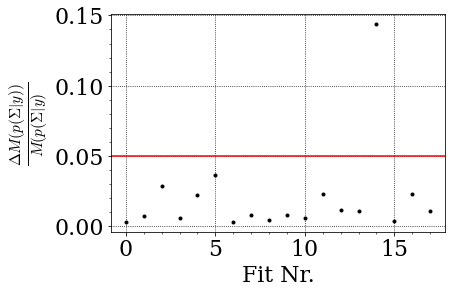

In [12]:
fig, ax = plt.subplots()
ax.plot(np.arange(18),np.abs(np.array(alt_diagnostics_df.loc[['mcse']])[0]/np.array(alt_diagnostics_df.loc[['sigma_median']])[0]),'.')
ax.set_xlabel('Fit Nr.')
ax.set_ylabel('$\\frac{\Delta M(p(\Sigma|y))}{M(p(\Sigma|y)}$')
#ax.set_ylim([0,0.5])
ax.axhline(y=0.05,color='red')
plt.show()
fig.savefig('./plots/mcse.pdf',format='pdf',bbox_inches='tight',dpi=1000)

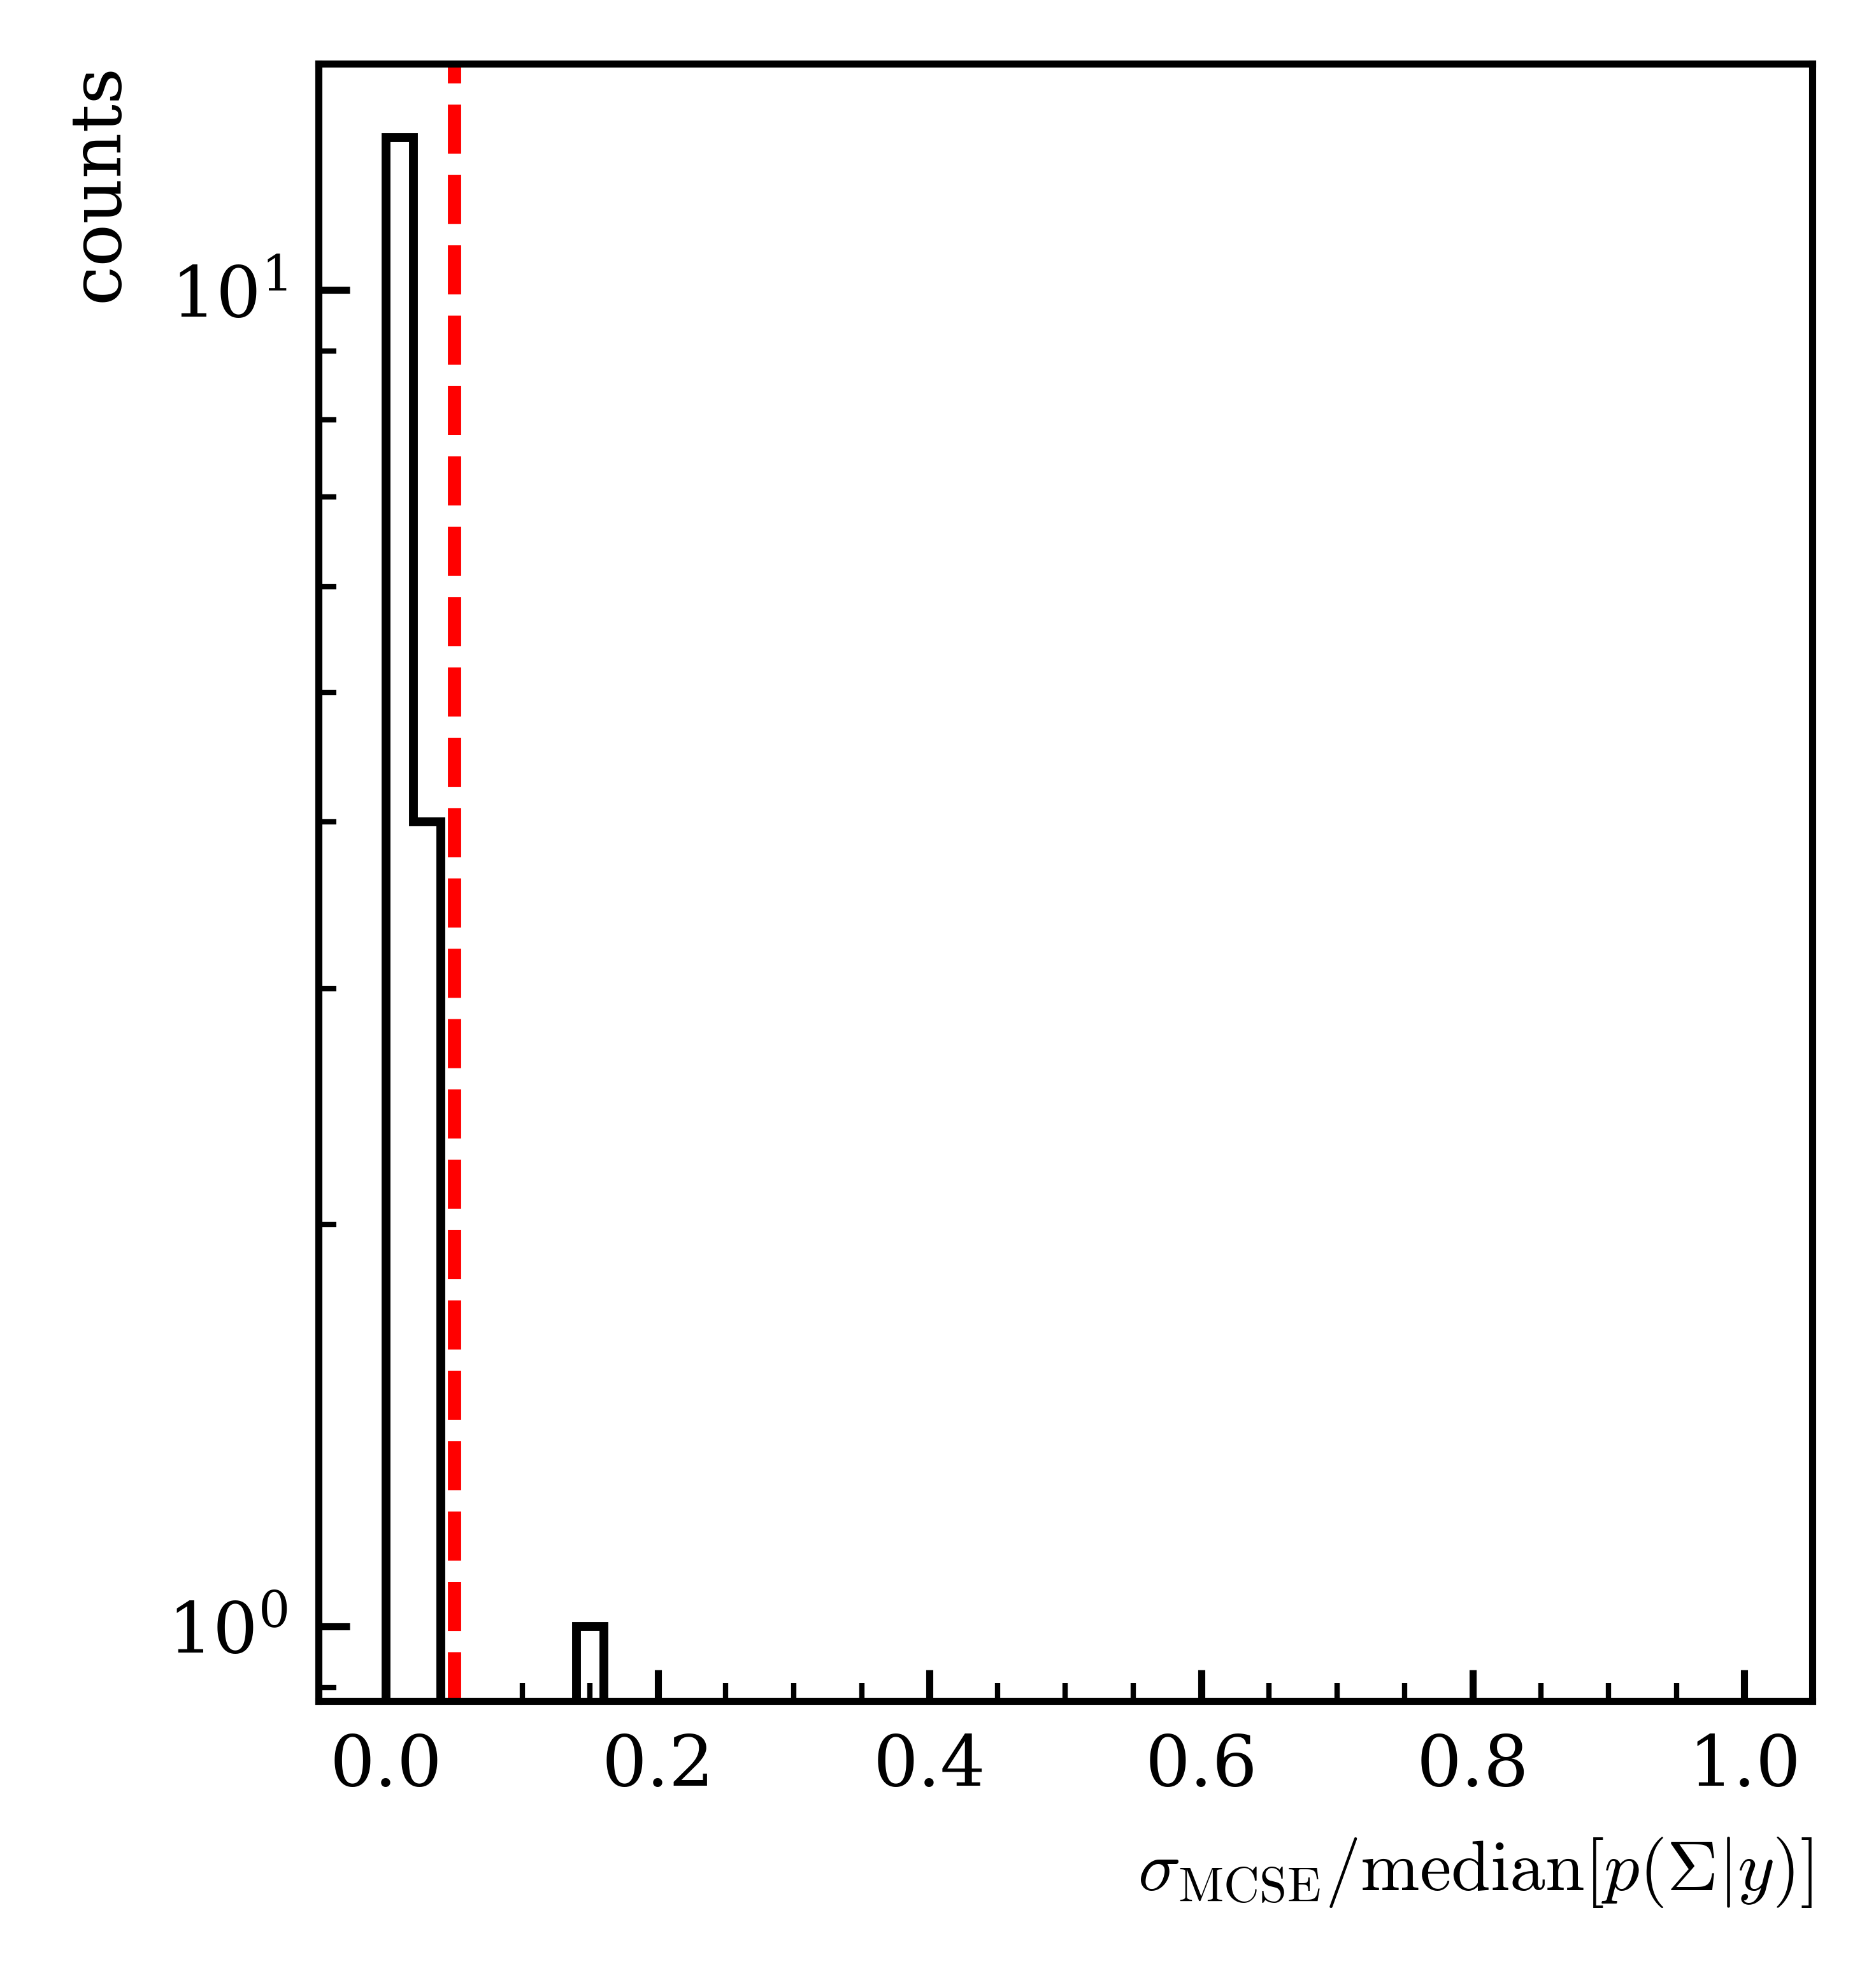

In [3]:
plt.rcParams['font.size']=8
fig, ax = plt.subplots(figsize=([15.3728/2.54/2,8.6472/2.54]),dpi=1000)

ax.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)/np.array(diagnostics_df.loc['sigma_median'].values)),histtype='step',log=True,range=[0,1],bins=50)
#ax.set_xlim([0,1])
#plt.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)),histtype='step',bins=20)
ax.set_xlabel(r'$\sigma_\mathrm{MCSE}/\mathrm{median}[p(\Sigma|y)]$',horizontalalignment='right',x=1.0)
ax.set_ylabel('counts',horizontalalignment='right',y=1.0)
ax.axvline(x=0.05,color='red',linestyle='--')
ax.grid(False)
ax.tick_params(axis='both',which='both',direction='in')
#plt.xscale('log')
#plt.savefig('./plots/toyMC_mcse_hist_raw.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()
fig.savefig('./plots/mcse_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')

In [10]:
for col in alt_sigma_df.columns:
    data = [alt_sigma_df[col].values[i*5000:(i+1)*5000] for i in range(4)]
    #print(data)
    rhat = az.rhat(np.array(data))
    diagnostics_df[col]['rhat']=rhat

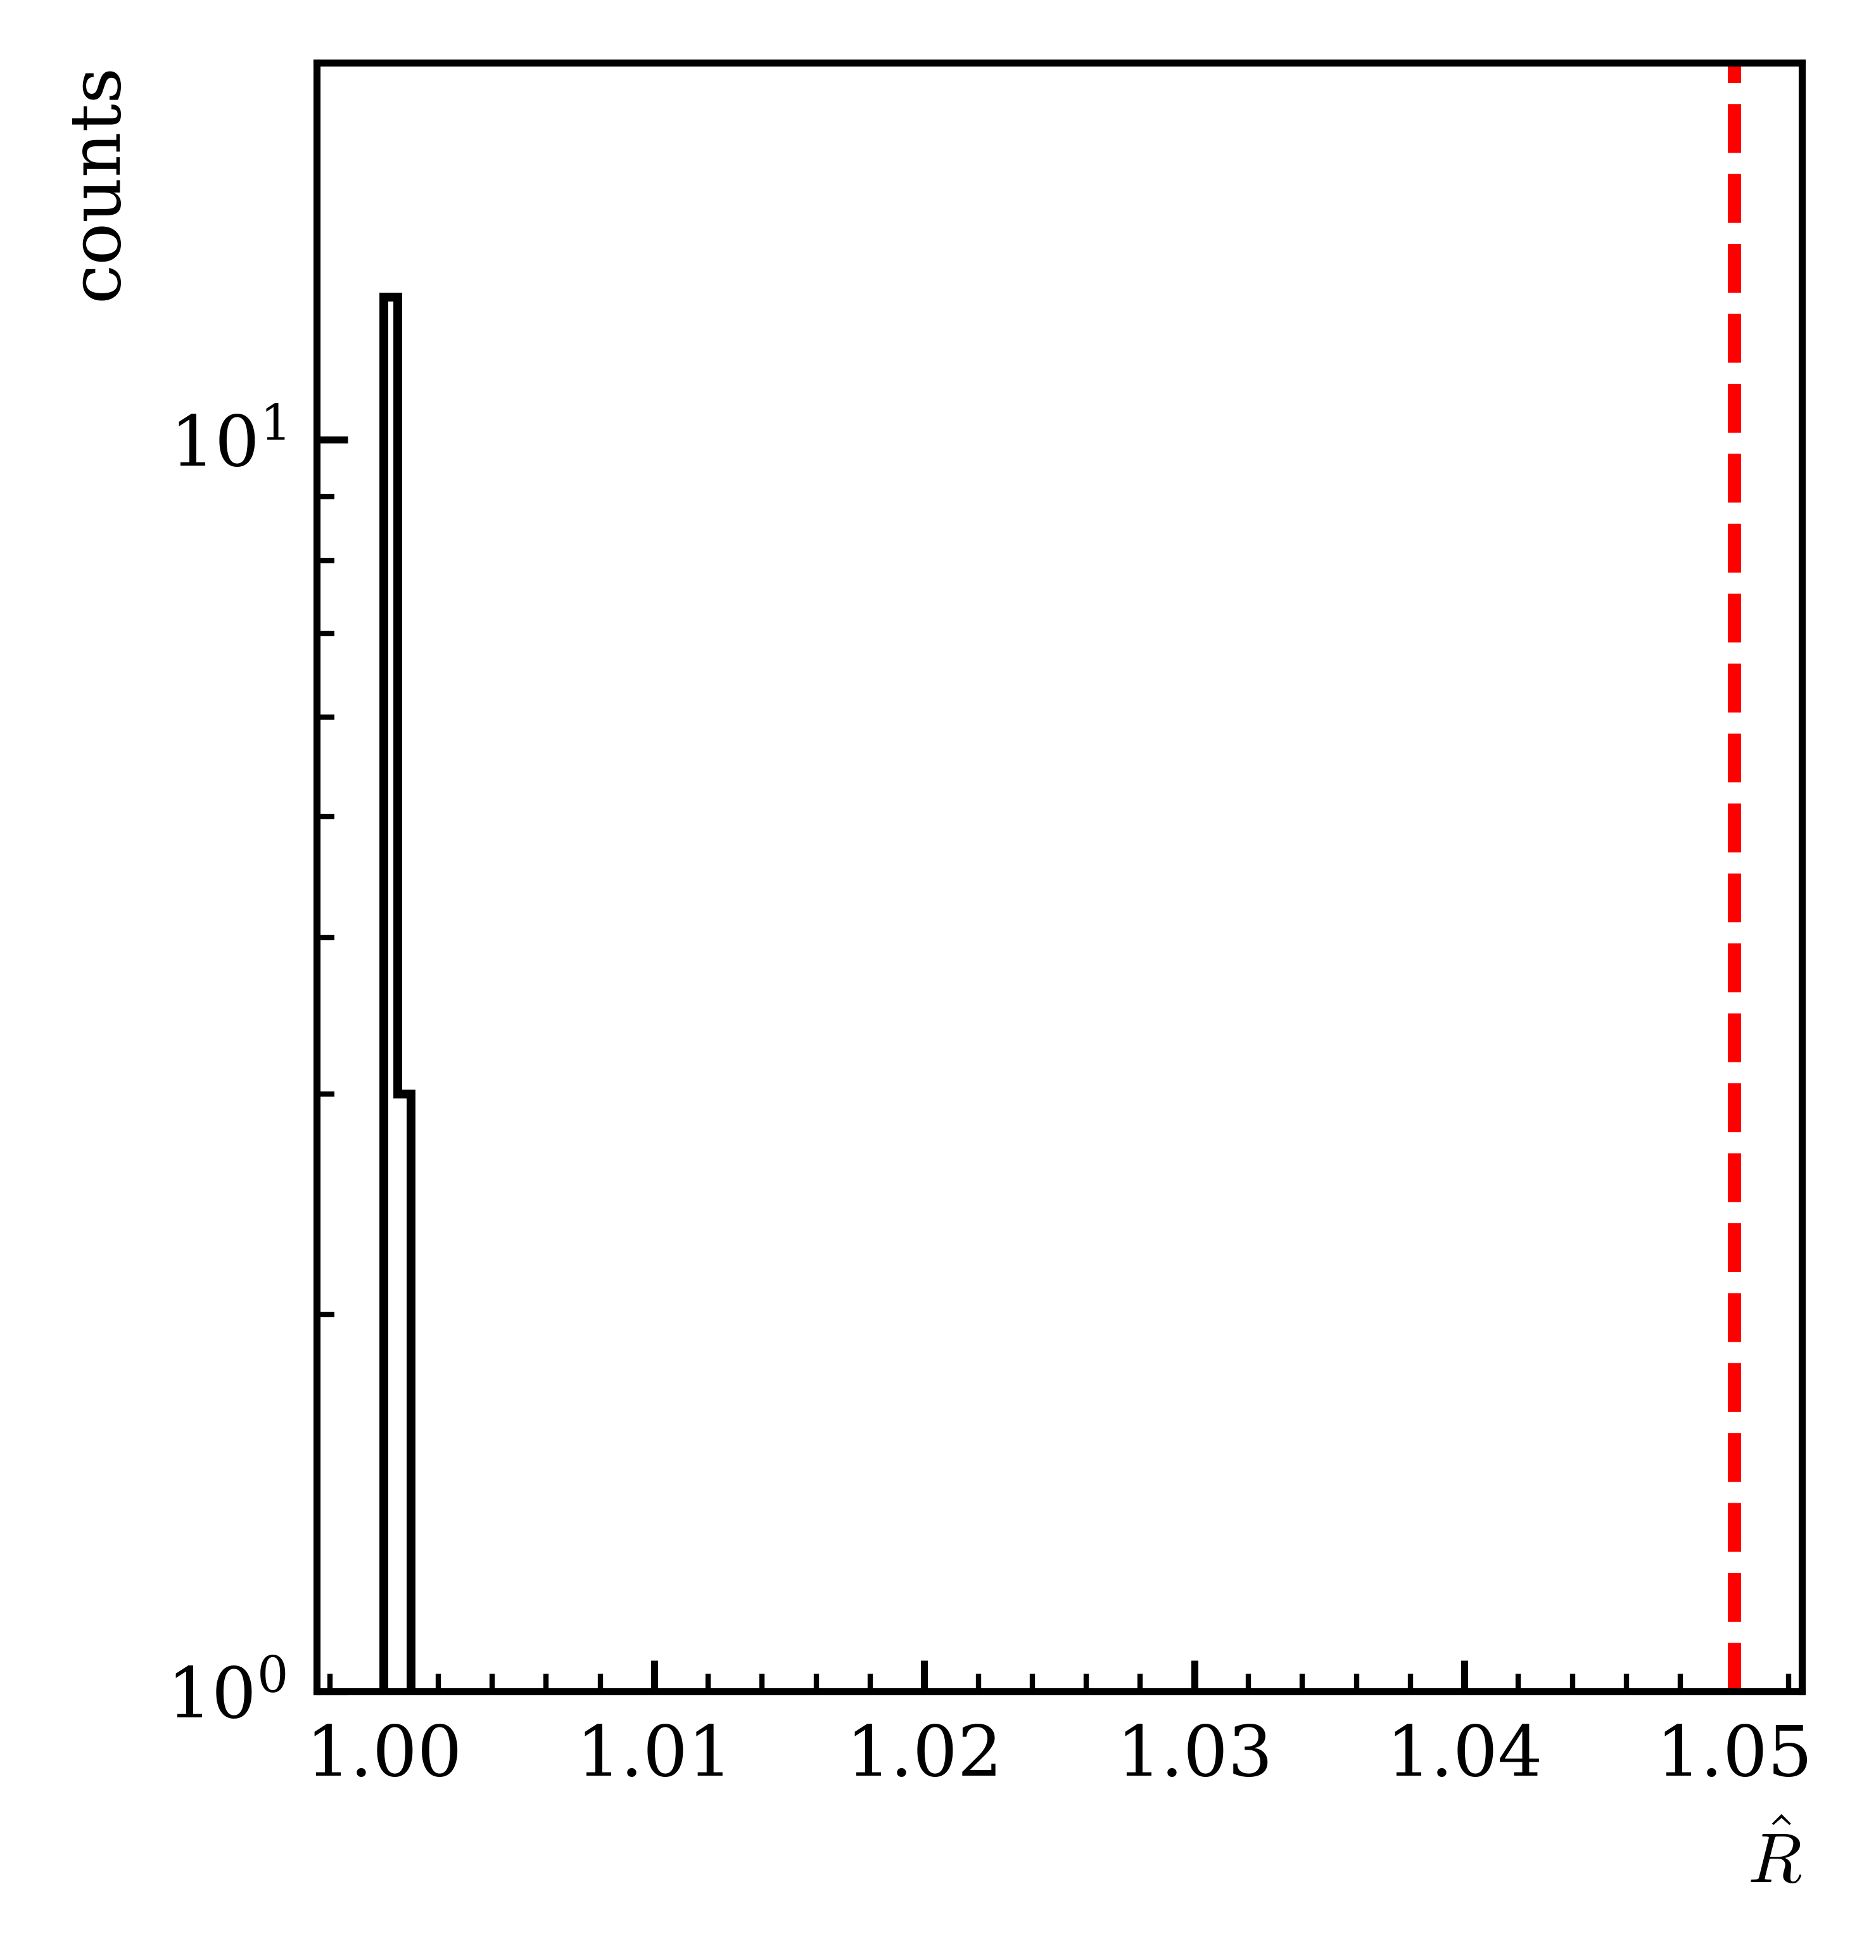

In [35]:
plt.rcParams['font.size']=8
fig, ax = plt.subplots(figsize=([15.3728/2.54/2,8.6472/2.54]),dpi=1000)
ax.tick_params(axis='both',which='both',direction='in')
ax.hist(diagnostics_df.loc['rhat'].values,histtype='step',log=True,range=([1.00,1.05]),bins=100)
#ax.set_xlim([0,1])
#plt.hist(np.abs(np.array(diagnostics_df.loc['mcse'].values)),histtype='step',bins=20)
ax.set_xlabel(r'$\hat{R}$',horizontalalignment='right',x=1.0)
#ax.set_xlabel(r'$\sigma_\mathrm{MCSE}/\mathrm{median}[p(\Sigma|y)]$',horizontalalignment='right',x=1.0)
ax.set_ylabel('counts',horizontalalignment='right',y=1.0)
ax.set_ylim([1e0,2e2])
ax.axvline(x=1.05,color='red',linestyle='--')
ax.grid(False)
ax.set_ylim([1e0,2e1])
#plt.xscale('log')
#plt.savefig('./plots/toyMC_mcse_hist_raw.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()
fig.savefig('./plots/rhat_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')

In [45]:
delta_1=np.array(df_fr.iloc[0].values)
delta=np.array(df_fr_total.iloc[0].values)
delta_2=delta-delta_1
delta_2

array([0.07, 0.06, 0.03, 0.02, 0.  , 0.  , 0.13, 0.03, 0.03, 0.06, 0.01,
       0.  , 0.02, 0.03, 0.03, 0.04, 0.02, 0.  ])

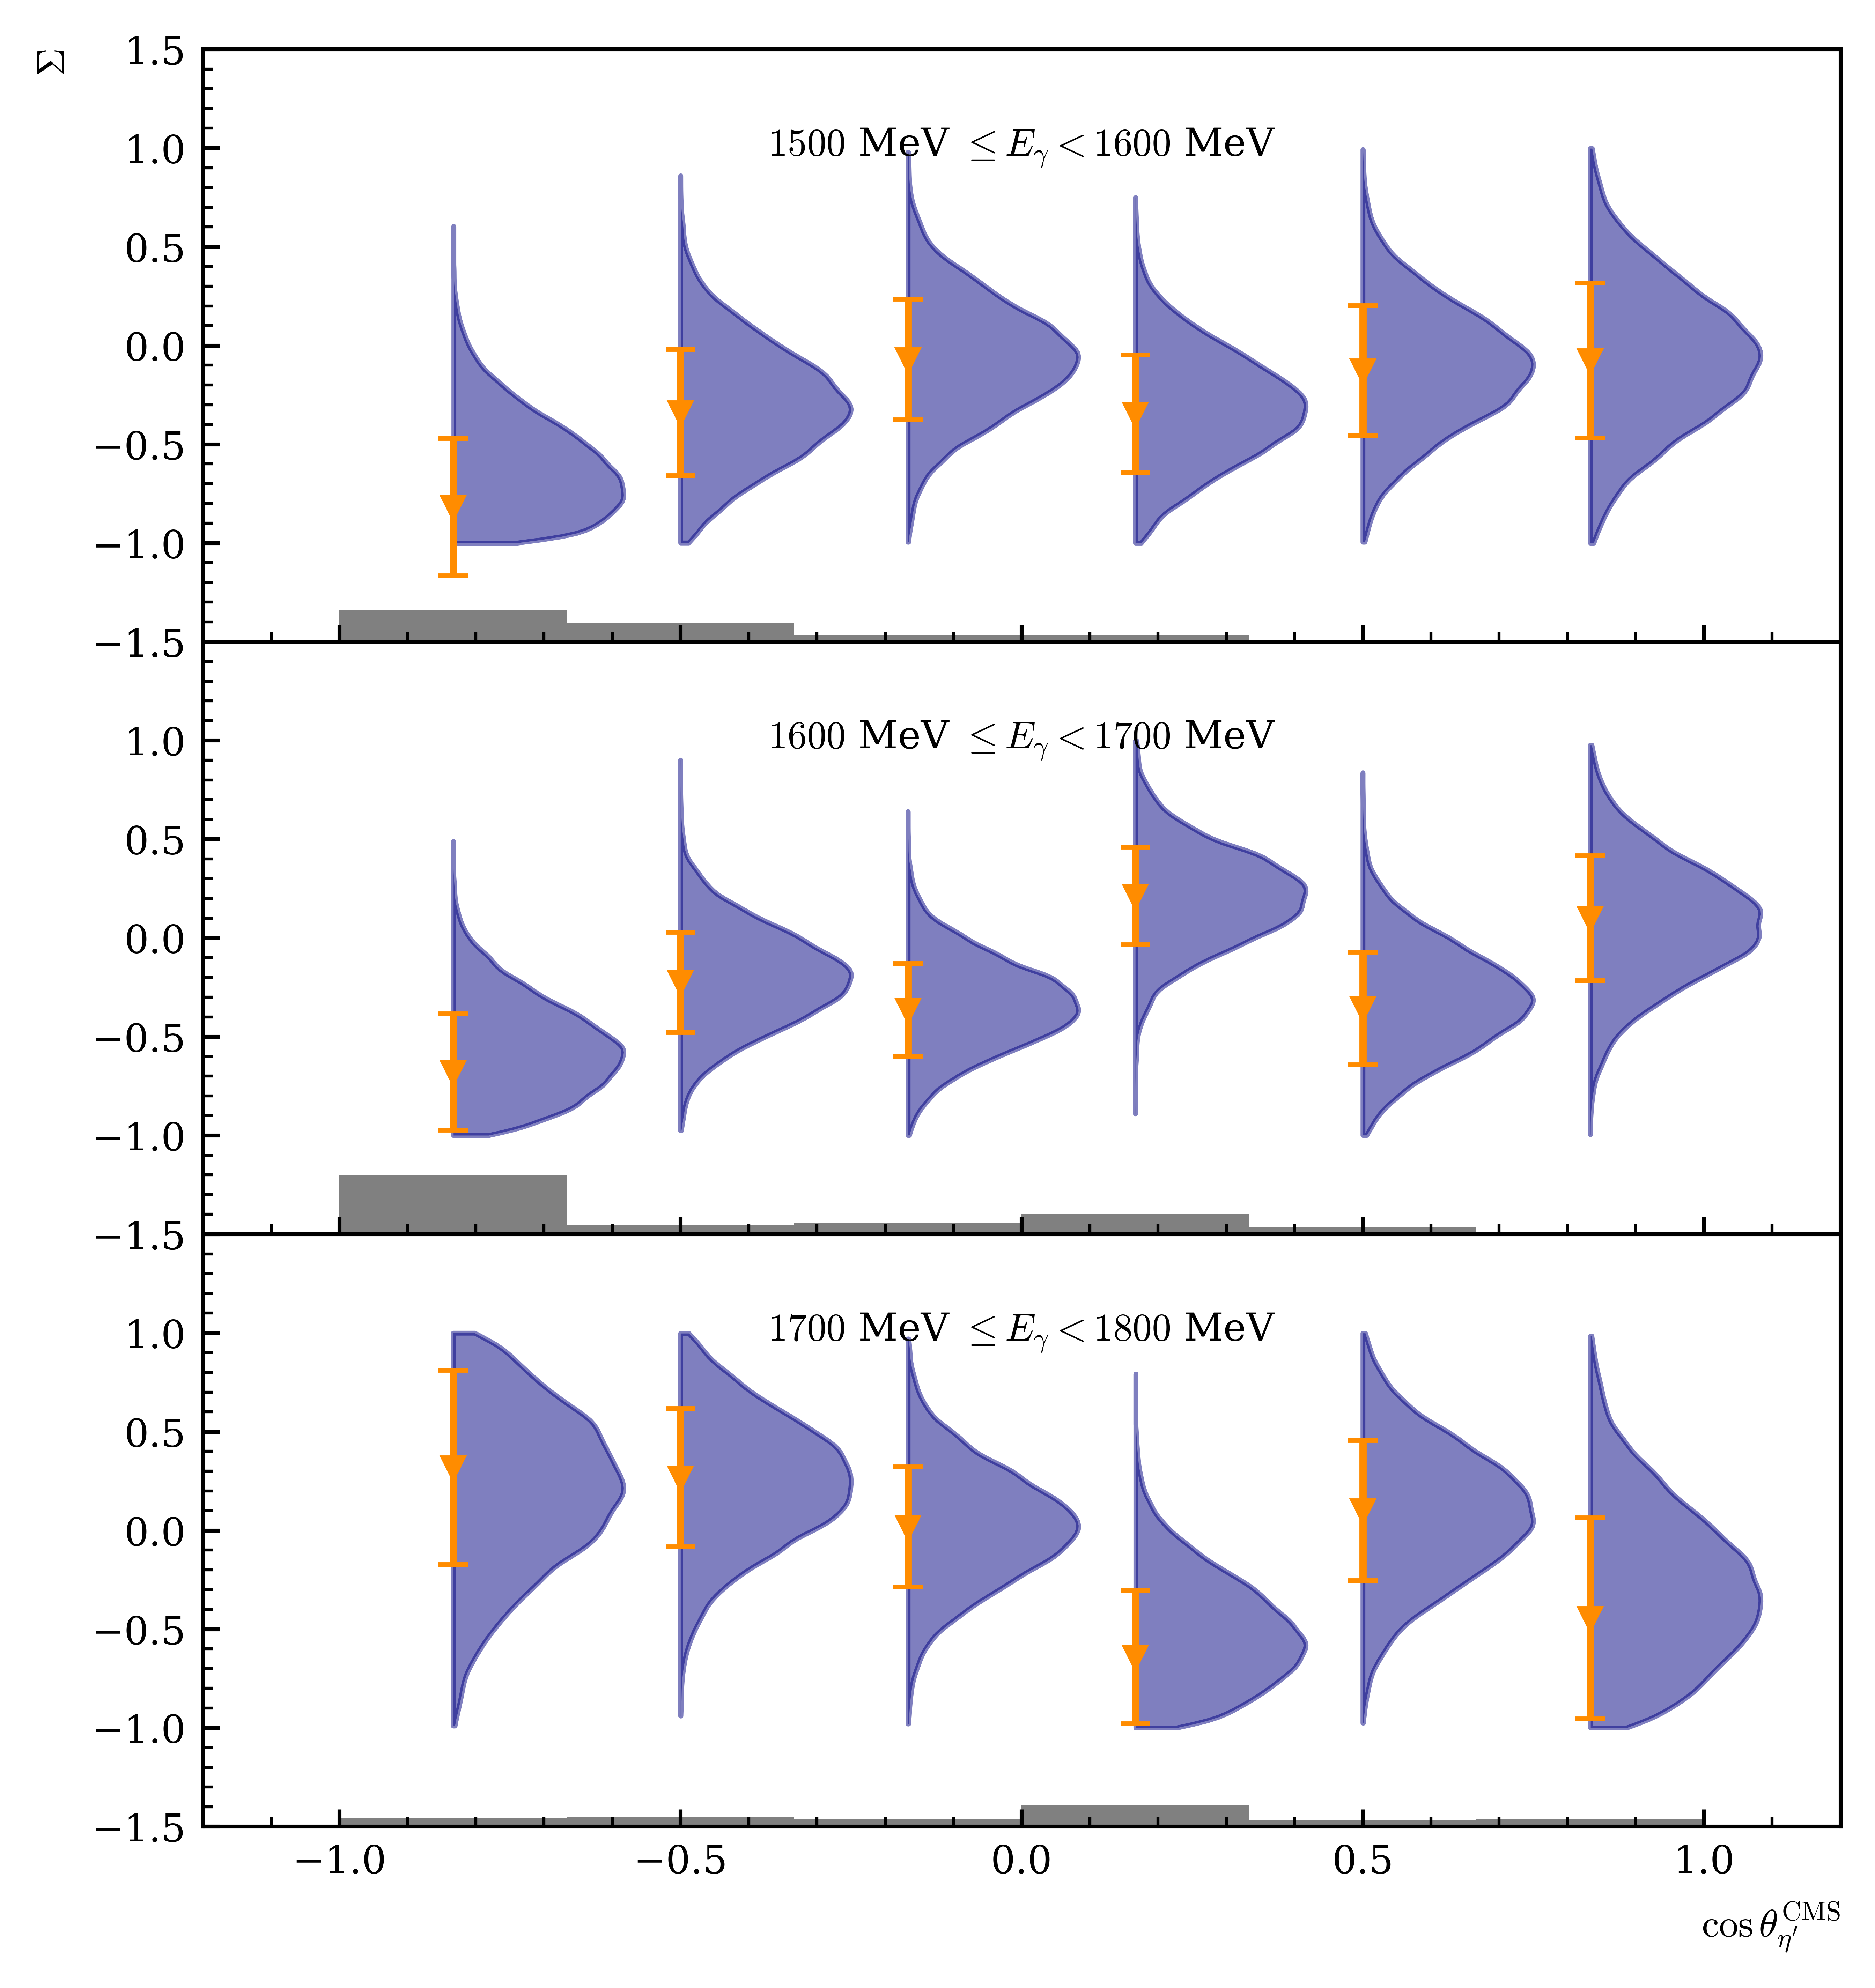

In [58]:
plt.rcParams['font.size']=8
plt.rcParams['axes.grid']=False
fig,ax = plt.subplots(3,1,sharey='col',dpi=1000,figsize=[15.3728/2.54,0.8*21.41492/2.54])
plt.subplots_adjust(wspace=0, hspace=0)
counter=0
for i in range(1):
    for j in range(3):
        if(j==0 and i==0):
            ax[j].set_ylabel('$\Sigma$',horizontalalignment='right',y=1.0)
        if(j==2):
            ax[j].set_xlabel('$\cos\\theta_{\eta\'}^{\mathrm{CMS}}$',horizontalalignment='right',x=1.0)
        ax[j].set_xlim([-1.2,1.2])
        ax[j].set_ylim([-1.5,1.5])
        ax[j].tick_params(axis='both',which='both',direction='in')

        x=[-1+2/6/2+(i)*2/6 for i in range(6)]

        if(counter<11):
            #plot point estimates from event based fit
            #ax[j].errorbar(x=x,y=sigma_unbinned_df['sigma'][counter*6:counter*6+6],
            #                  yerr=sigma_unbinned_df['sigma_err'][counter*6:counter*6+6],
            #                  fmt='v',markersize=4.,color='darkorange',label='Event based fit')
            #plot corrected point estimates
            #get sigma 2pi0 and fraction in current ebin
            #sigma
            sigma_2pi0=-1*np.array([df_bkg[f"ebin{counter:02d}costbin{-j+5:02d}"]['sigma'] for j in range(6)])
            #error
            sigma_2pi0_err=np.array([df_bkg[f"ebin{counter:02d}costbin{-j+5:02d}"]['sigma_err'] for j in range(6)])
            #bkg fraction
            fr=np.array([df_fr[f"ebin{counter:02d}costbin{j:02d}"].values[0] for j in range(6)])
            #neglected bkg fraction
            fr_sys=np.array([df_fr_total[f"ebin{counter:02d}costbin{j:02d}"].values[0] for j in range(6)])-fr
            #sigma_meas=a*sigma_true+b*sigma_bkg
            sigma_meas=np.array(sigma_unbinned_df['sigma'][counter*6:counter*6+6])
            sigma_true=(sigma_meas-fr*sigma_2pi0)/(1-fr)
            #systematic deviation with neglected bkg
            sigma_sys_dev_low=np.abs(sigma_true-(sigma_meas-fr*sigma_2pi0-fr_sys)/(1-fr-fr_sys))
            sigma_sys_dev_up=np.abs(sigma_true-(sigma_meas-fr*sigma_2pi0+fr_sys)/(1-fr-fr_sys))
            #take only the maximum values
            sigma_sys_dev=np.maximum(sigma_sys_dev_low,sigma_sys_dev_up)
            if j==0:
                r=0.05
            else:
                r=0.08
            sigma_sys_pol=r*sigma_true
            sigma_sys_err=np.sqrt(sigma_sys_dev**2+sigma_sys_pol**2)
            #print(fr_sys)
            

            #correct errors
            old_err=np.array(sigma_unbinned_df['sigma_err'][counter*6:counter*6+6])
            err_true=np.sqrt(((old_err)/(1-fr))**2
                            +(sigma_2pi0_err*fr/(1-fr))**2)
            ax[j].errorbar(x=x,y=sigma_true,
                              yerr=err_true,
                              fmt='v',markersize=4.,color='darkorange',label='Event based fit (alt)')
            #plot sigma posterior obtained from event based fit
            #vp=ax[j].violinplot([sigma_df[f"ebin{counter:02d}costbin{j:02d}"] for j in range(6)],x,
            #                    showmeans=False, showextrema=False, showmedians=False,widths=0.5)
            #plot alt results considering bkg contributions
            vp_alt=ax[j].violinplot([alt_sigma_df[f"ebin{counter:02d}costbin{j:02d}"] for j in range(6)],x,
                                showmeans=False, showextrema=False, showmedians=False,widths=0.5)
  
            ax[j].text(0,1,f'${1500+counter*100}$ MeV $\leq E_\gamma < {1500+(counter+1)*100}$ MeV',
                       fontsize=8,ha='center',va='center')
            #cosmetics
            for b in vp['bodies']:
                # get the center
                m = np.mean(b.get_paths()[0].vertices[:, 0])
                # modify the paths to not go further right than the center
                b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
                b.set_alpha(.5)
                b.set_color('navy')
            for b in vp_alt['bodies']:
                # get the center
                m = np.mean(b.get_paths()[0].vertices[:, 0])
                # modify the paths to not go further right than the center
                b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
                b.set_alpha(.5)
                b.set_color('navy')
            #plot systematic errors
            ax[j].bar(x=x,height=sigma_sys_err,bottom=-1.5,width=1/3,color='gray')
            #compare with collins results
            #ax[j].errorbar(x=np.cos(np.array(collins[j]['costheta'])*np.pi/180.),y=collins[j]['sigma'],
            #                  yerr=collins[j]['sigma_err'],
            #                  fmt='s',markersize=4.,color='black',label='Collins et al.')
        counter+=1
lines,labels = ax[0].get_legend_handles_labels() 
patch = mpatches.Patch(color='navy', label='bayesian fit (event based)',alpha=.5)
patch1 = mpatches.Patch(color='navy', label='bayesian fit (event based alt)',alpha=.1)

lines.append(patch)
lines.append(patch1)

#plt.legend(handles=lines,bbox_to_anchor=(1.4,-0.1))        
plt.show()
#fig.savefig(f'./plots/sigma_etap.pdf',format='pdf',bbox_inches='tight',dpi=1000)
fig.savefig(f'./plots/sigma_etap_sys.pdf',format='pdf',bbox_inches='tight',dpi=1000)

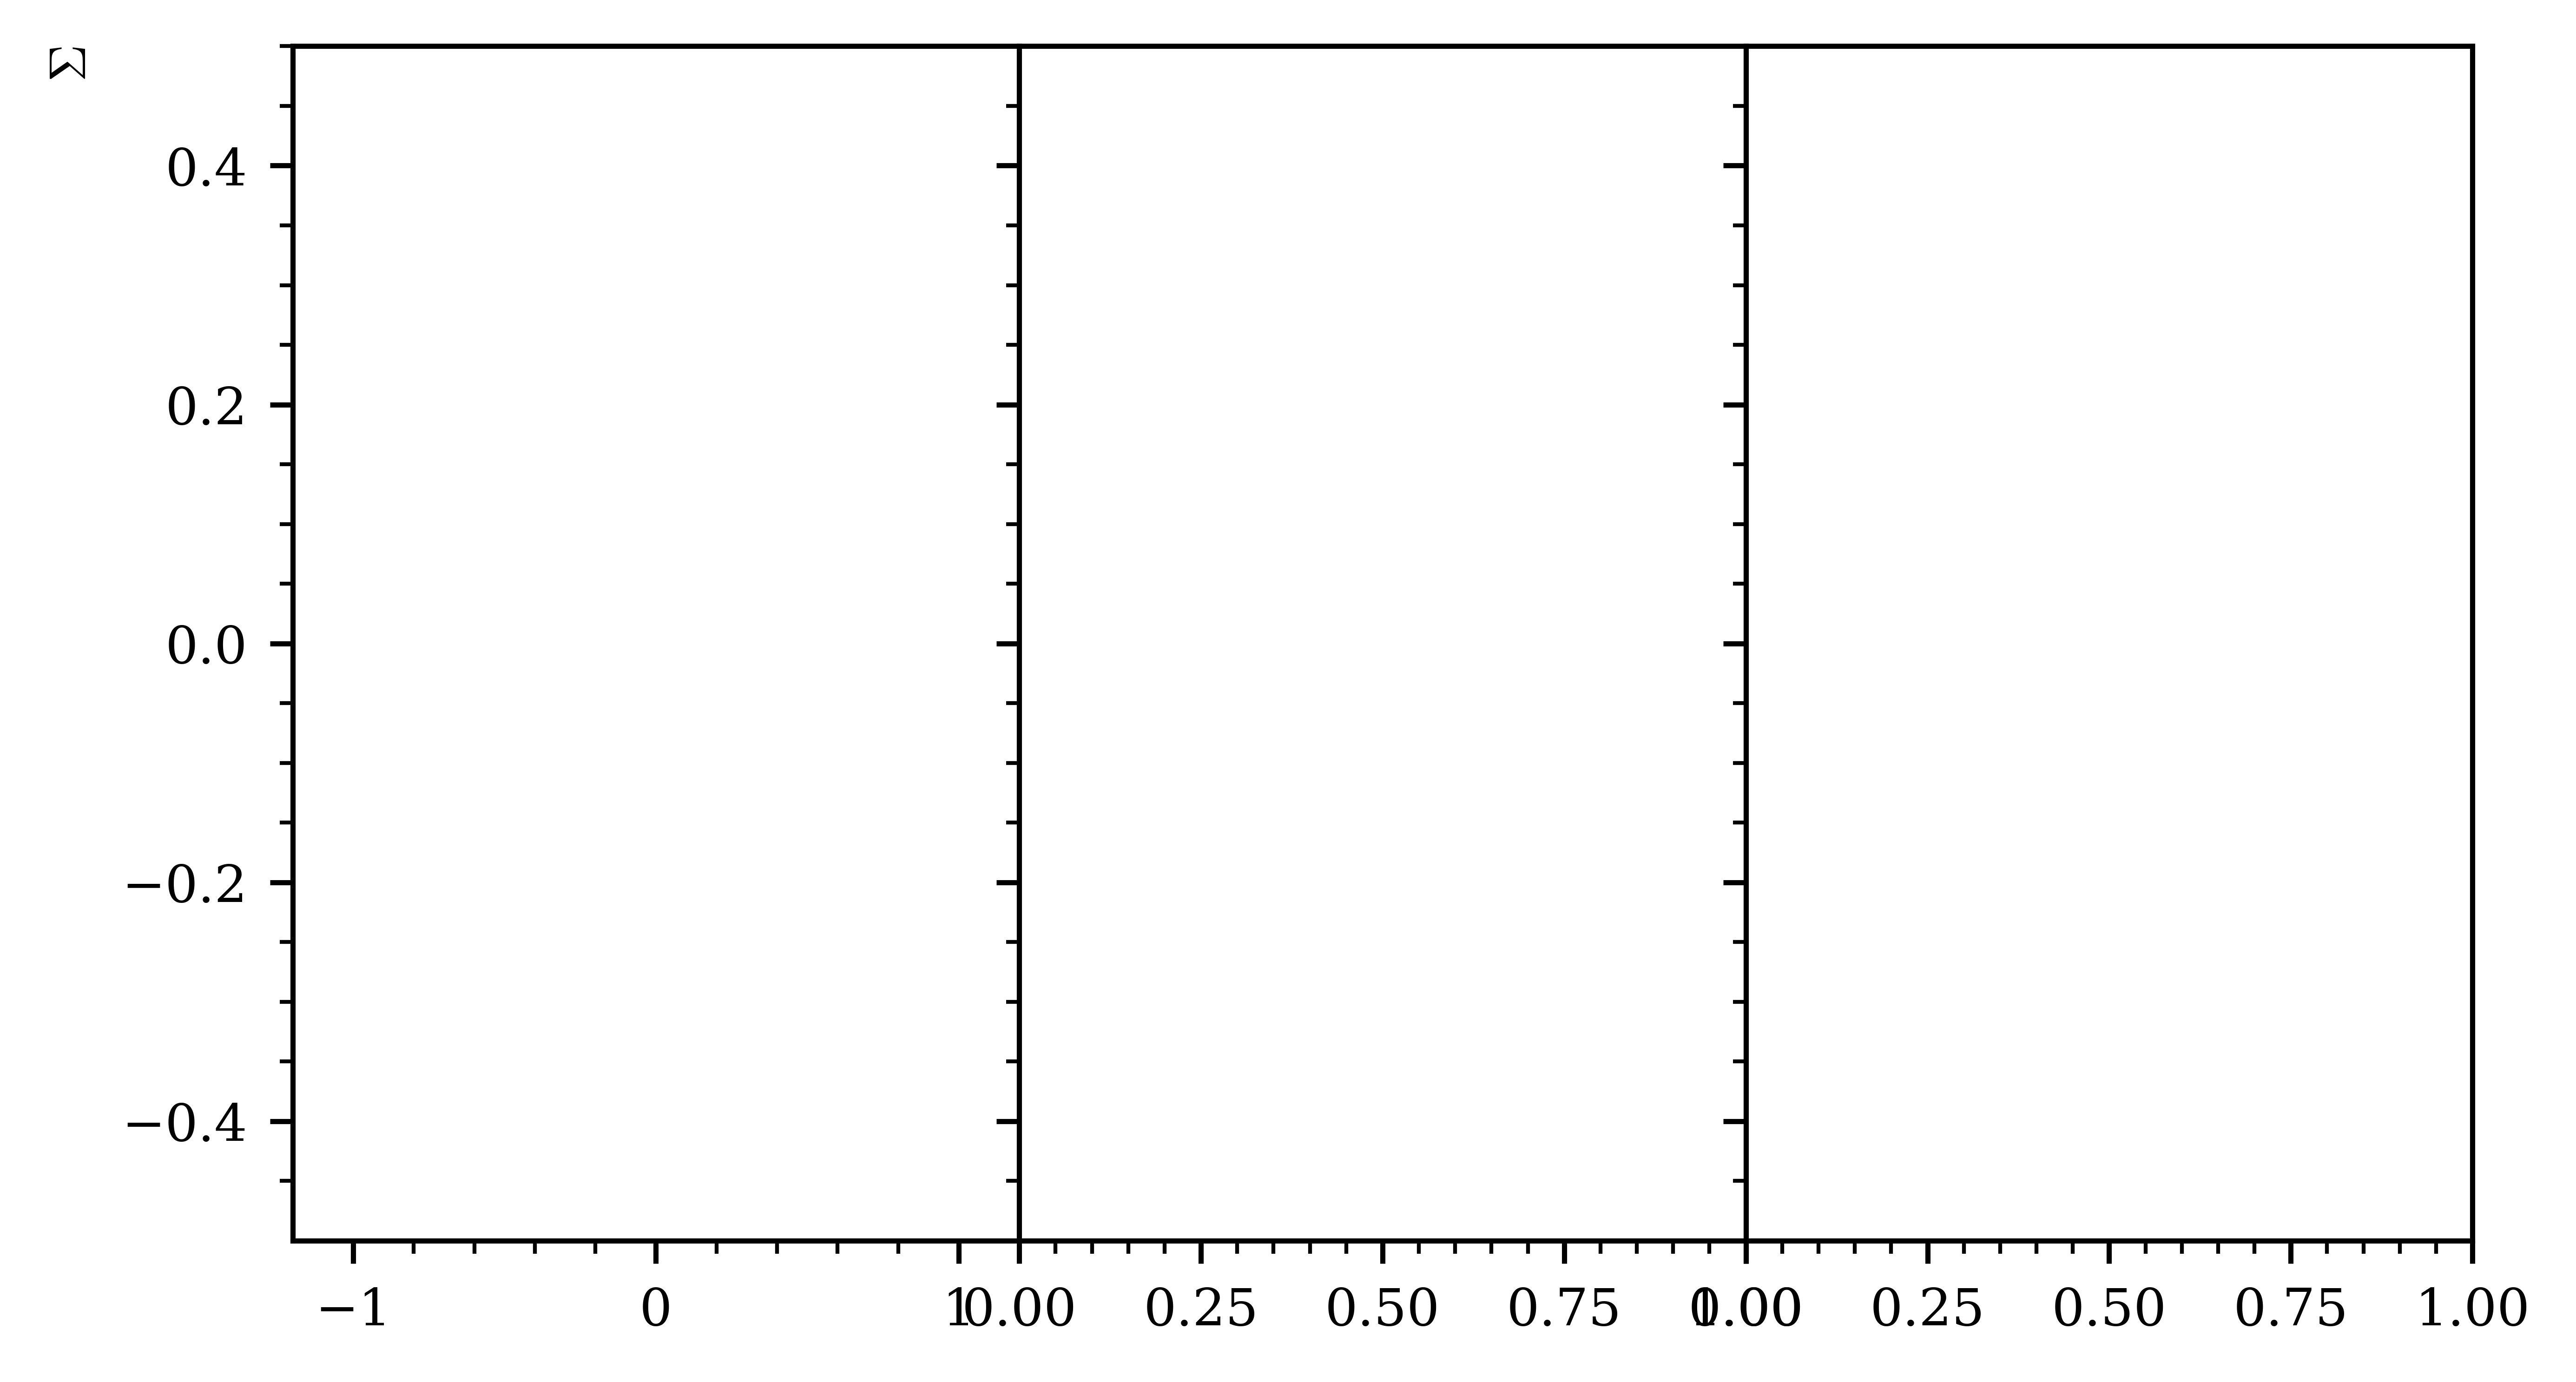

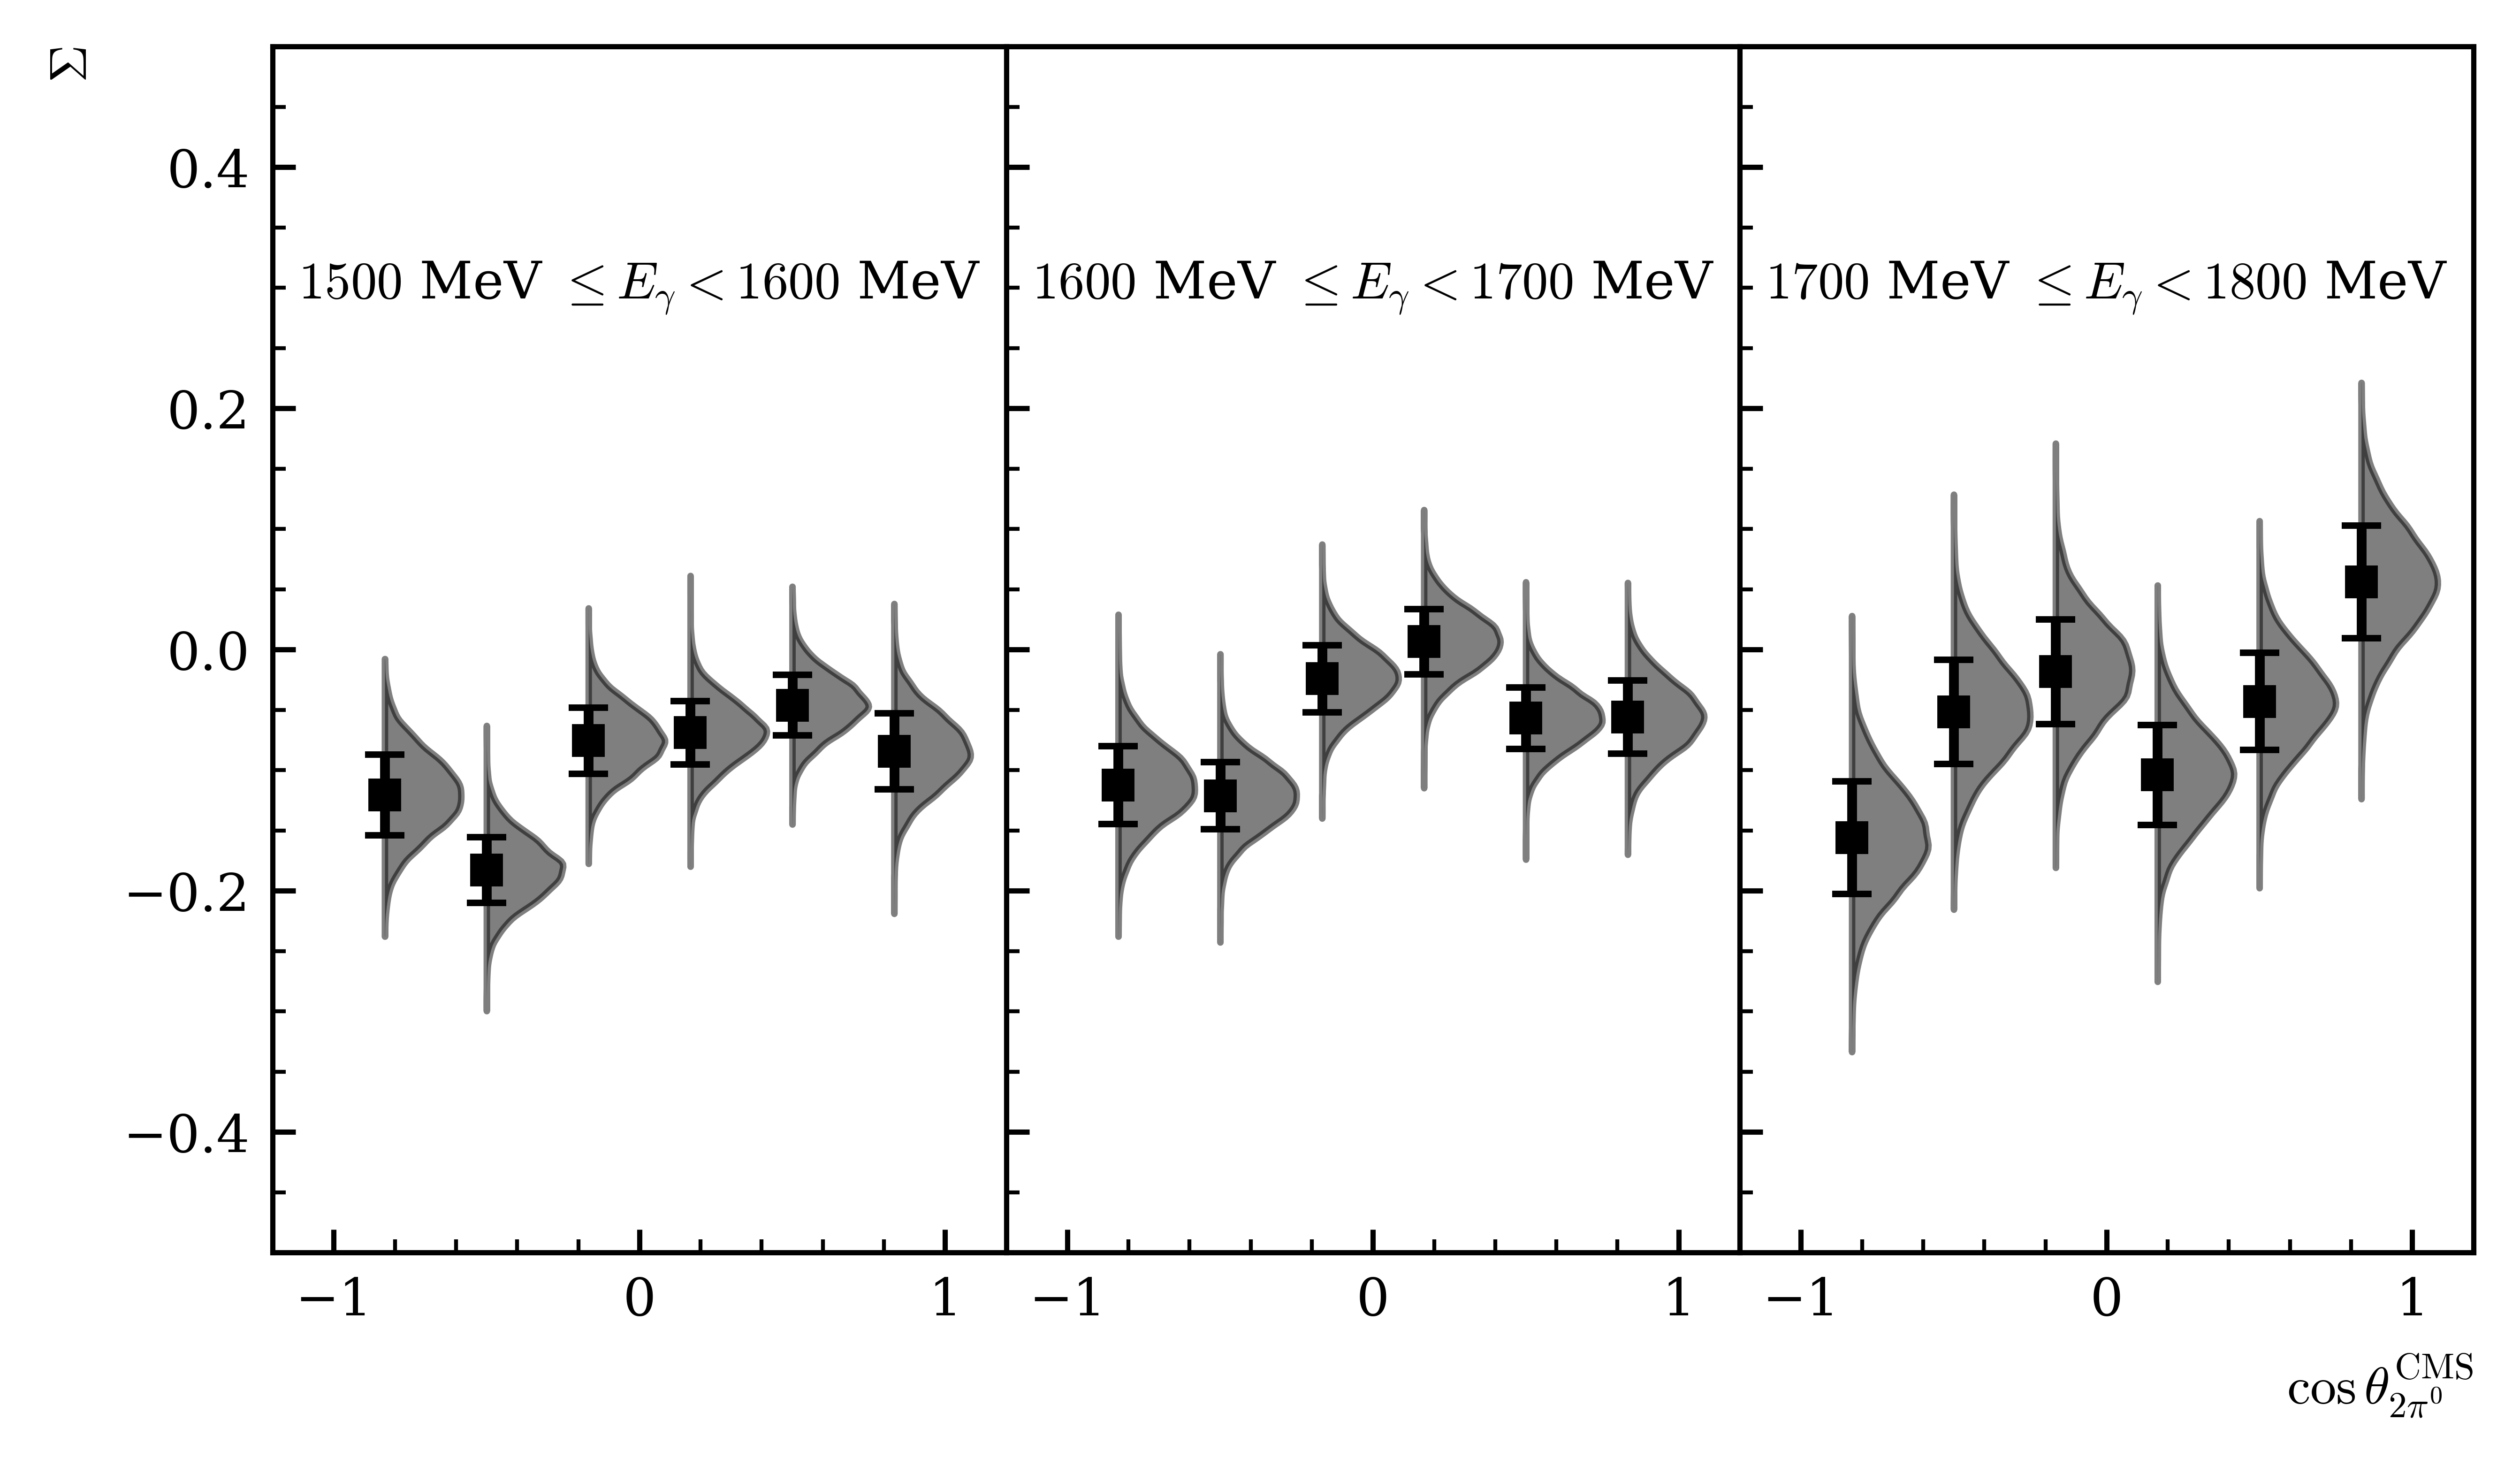

In [33]:
plt.rcParams['font.size']=8
plt.rcParams['axes.grid']=False
fig,ax = plt.subplots(1,3,sharey='row',dpi=1000,figsize=[15.3728/2.54,8.6472/2.54])
plt.subplots_adjust(wspace=0, hspace=0)
counter=0
sigma_2pi0_df=pd.read_csv('./sigma_2pi0.csv')
for i in range(1):
    for j in range(3):
        if(j==0 and i==0):
            ax[j].set_ylabel('$\Sigma$',horizontalalignment='right',y=1.0)
        if(j==2):
            ax[j].set_xlabel('$\cos\\theta_{2\pi^{0}}^{\mathrm{CMS}}$',horizontalalignment='right',x=1.0)
        ax[j].set_xlim([-1.2,1.2])
        ax[j].set_ylim([-0.5,0.5])
        ax[j].tick_params(axis='both',which='both',direction='in')

        x=[-1+2/6/2+(i)*2/6 for i in range(6)]
        #get sigma 2pi0 and fraction in current ebin
        #sigma
        sigma_2pi0=-1*np.array([df_bkg[f"ebin{counter:02d}costbin{-k+5:02d}"]['sigma'] for k in range(6)])
        #error
        sigma_2pi0_err=np.array([df_bkg[f"ebin{counter:02d}costbin{-k+5:02d}"]['sigma_err'] for k in range(6)])
        ax[j].errorbar(x=x,y=sigma_2pi0,yerr=sigma_2pi0_err,fmt='s',color='black',label='data (P. Mahlberg)',markersize=4)
        vp=ax[j].violinplot([sigma_2pi0_df[f"ebin{counter:02d}costbin{j:02d}"] for j in range(6)],x,
                                showmeans=False, showextrema=False, showmedians=False,widths=0.5)
        #cosmetics
        for b in vp['bodies']:
            # get the center
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
            b.set_alpha(.5)
            b.set_color('black')
        ax[j].text(0,0.3,f'${1500+counter*100}$ MeV $\leq E_\gamma < {1500+(counter+1)*100}$ MeV',
                       fontsize=8,ha='center',va='center')
        counter+=1
        lines,labels = ax[0].get_legend_handles_labels() 
        patch = mpatches.Patch(color='black', label='bayesian fit of $\Sigma_{\mathrm{bkg}}^{\mathrm{true}}$',alpha=.5)
        lines.append(patch)

        #plt.legend(handles=lines,bbox_to_anchor=(1.4,-0.1))
plt.show()
fig.savefig(f'./plots/sigma_2pi0.pdf',format='pdf',bbox_inches='tight',dpi=1000)


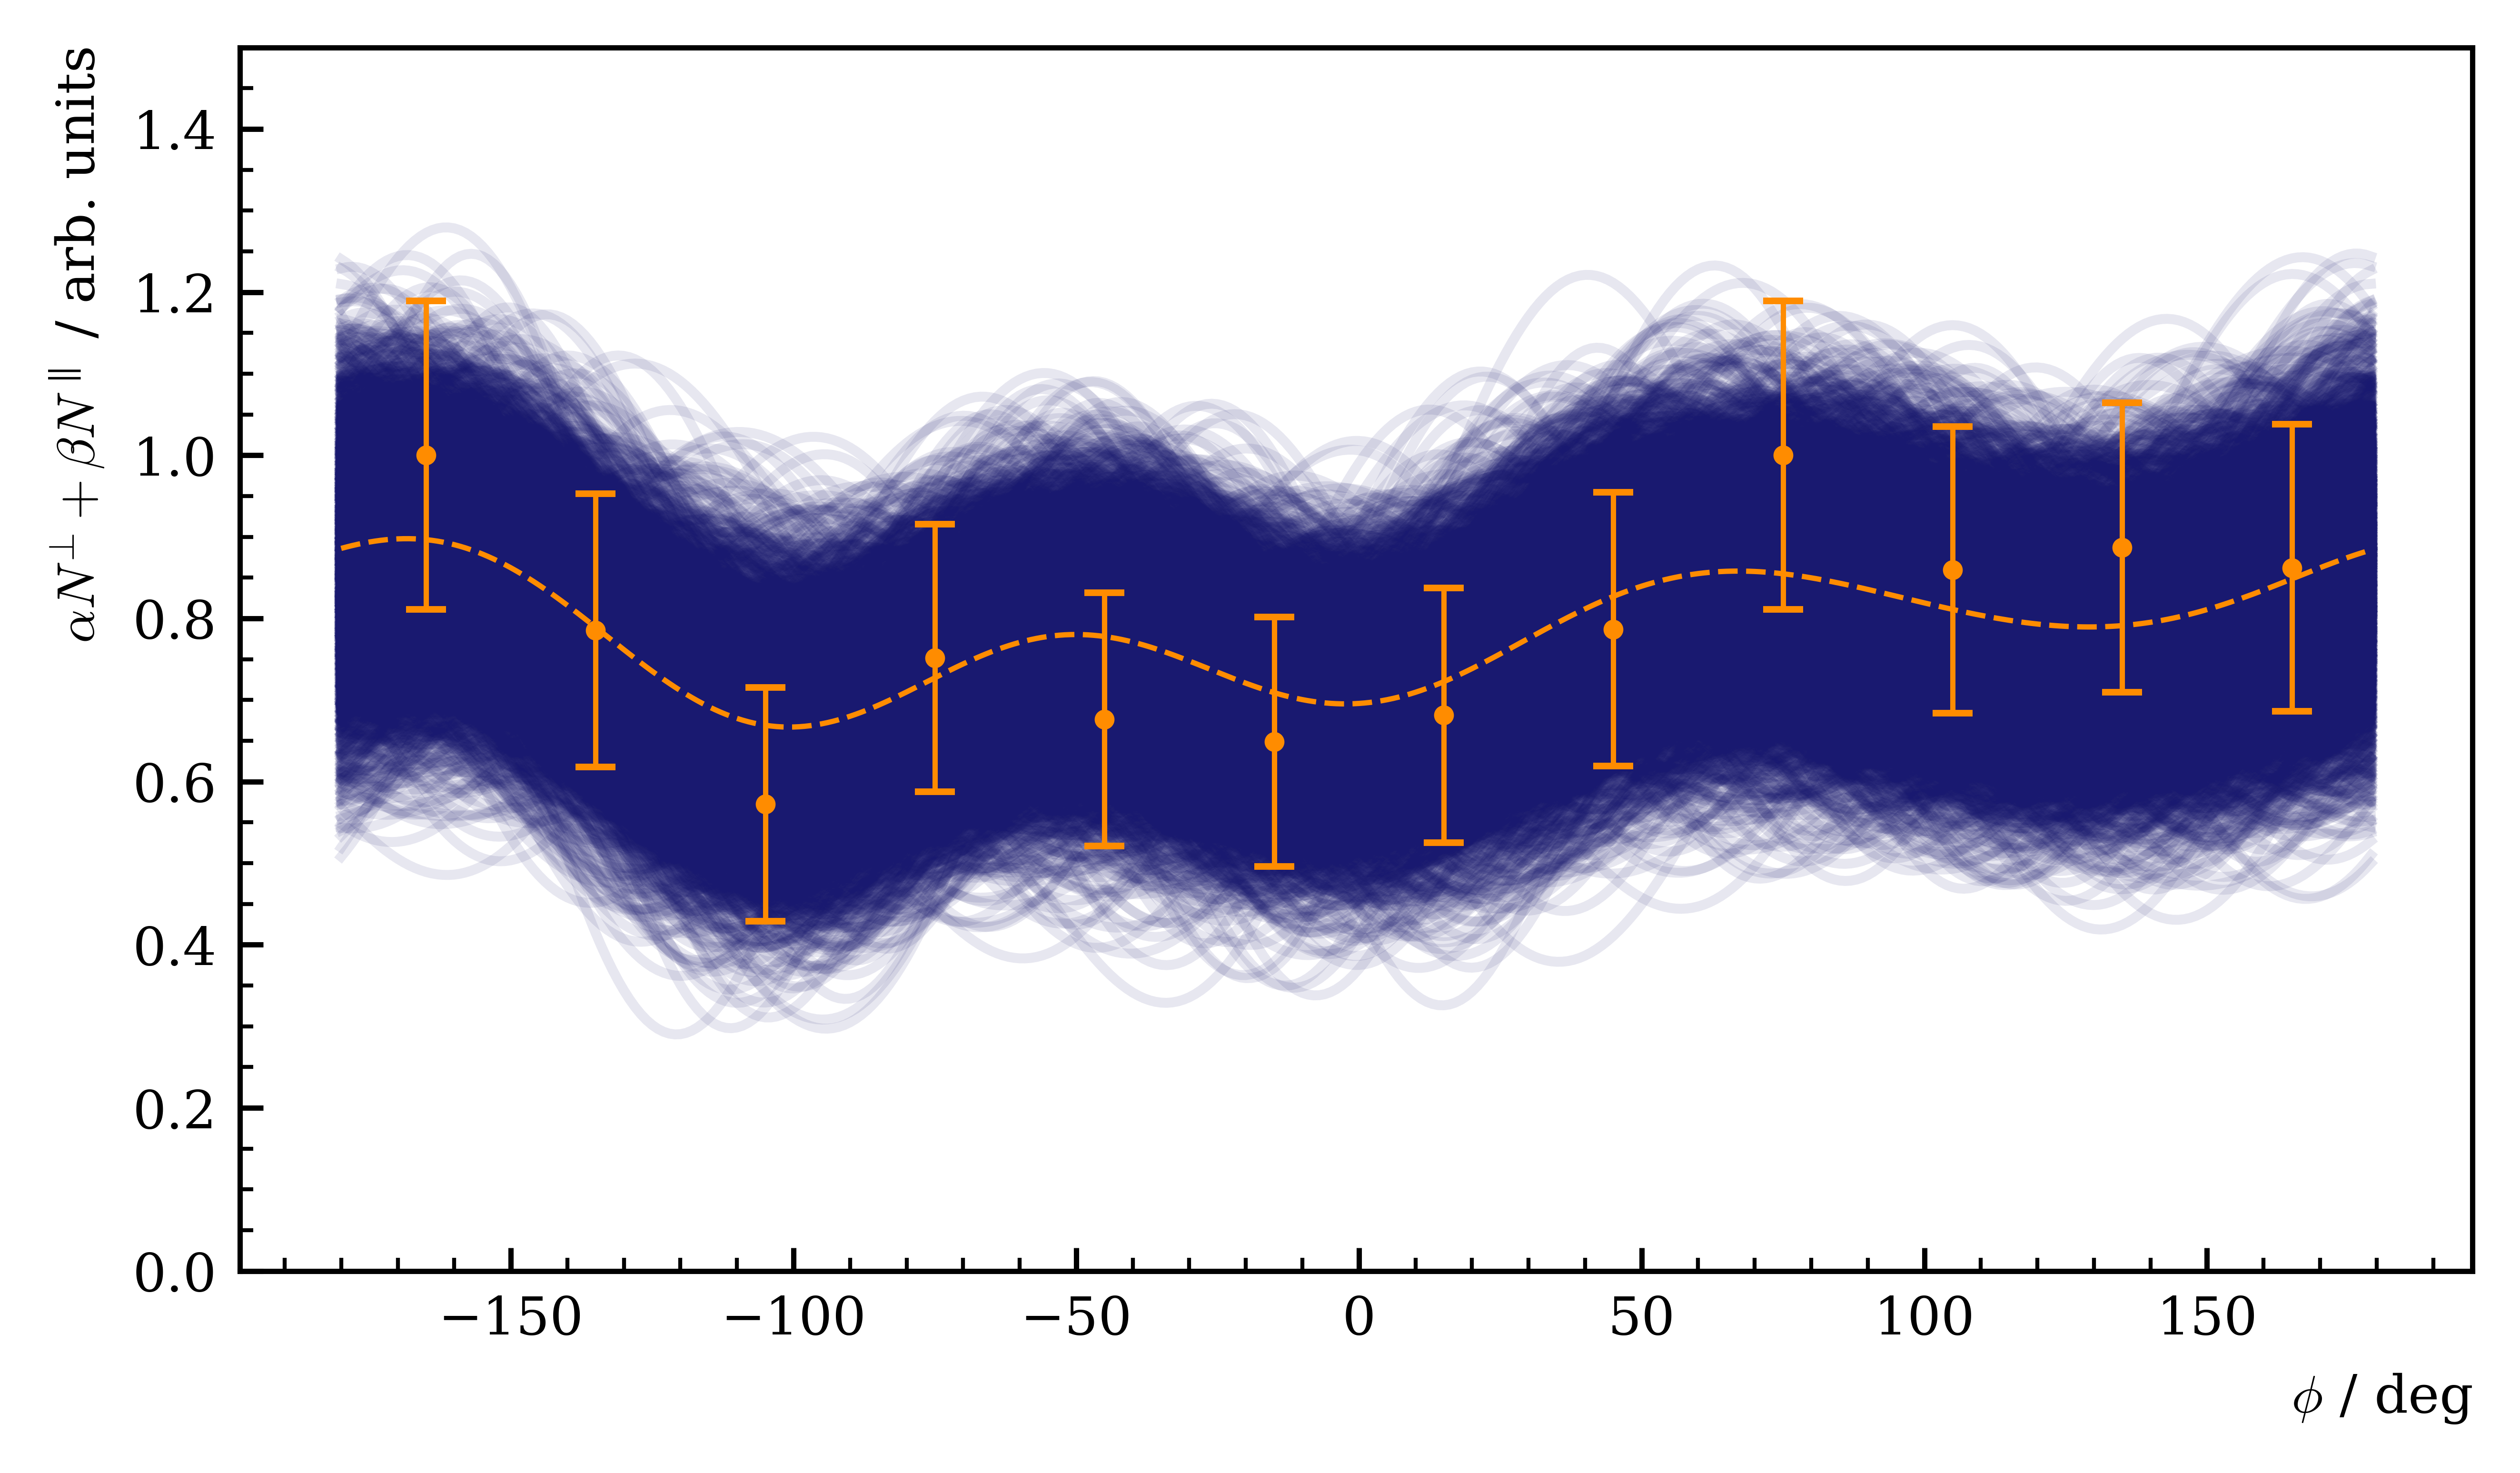

Warning in <TROOT::Append>: Replacing existing TH1: p45 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: m45 (Potential memory leak).


In [34]:
plt.rcParams['font.size']=8
plt.rcParams['axes.grid']=False
#read data
i=2 # define which bin to use
j=5
samples=pd.read_csv(f'samples_ebin{i:02d}costbin{j:02d}.csv',index_col=0)
summary=pd.read_csv(f'summary_ebin{i:02d}costbin{j:02d}.csv',index_col=0)

df=pd.read_csv(f"ebin{i:02d}/ebin{i:02d}costbin{j:02d}.txt",sep="\t")
df.columns=['pol','phi','weight']
#select only prmpt events
p45=df.loc[(df['weight']==1)&(df['pol']>0)].reset_index(drop=True)
m45=df.loc[(df['weight']==1)&(df['pol']<0)].reset_index(drop=True)
hp45=r.TH1F("p45","p45",12,-180,180)
hm45=r.TH1F("m45","m45",12,-180,180)
#histogram them
for i in p45['phi'].values:
    hp45.Fill(i)
for i in m45['phi'].values:
    hm45.Fill(i)
#normalize    
norm_p = 1./hp45.Integral()
norm_m = 1./hm45.Integral()
hp45.Scale(norm_p)
hm45.Scale(norm_m)
#build polarization weighted sum
pol_p45=np.abs(np.mean(p45['pol']))
pol_m45=np.abs(np.mean(m45['pol']))
hp45.Add(hp45,hm45,pol_m45/(pol_p45+pol_m45),pol_p45/(pol_m45+pol_p45))
hp45.Scale(1./hp45.GetMaximum())
#write values of histo to numpy array
asym=[]
asym_err=[]
phi=[]
for i in range(hp45.GetNbinsX()):
    asym.append(hp45.GetBinContent(i+1))
    asym_err.append(hp45.GetBinError(i+1))
    phi.append(hp45.GetBinCenter(i+1))
asym=np.array(asym)
asym_err=np.array(asym_err)
phi=np.array(phi)
xx=np.arange(-180,180)

#plot results
fig, ax = plt.subplots(figsize=[15.3728/2.54,8.6472/2.54],dpi=1000)
ax.errorbar(x=phi,y=asym,yerr=asym_err,fmt='.',color='darkorange',zorder=3,label='data',elinewidth=0.8,markersize=4)
#get ALL values of fourier coeff
eff_list=[]
for i in range(4000):
    #get mean values of fourier coeff
    tmp_a=[samples[f'a[{j+1}]'][i] for j in range(4)]
    tmp_b=[samples[f'b[{j+1}]'][i] for j in range(4)]
    #put them in efficiency function
    def tmp_eff(x,c):
        val=1 # a0=0,b0=1
        for i in range(4):
            val+=tmp_a[i]*np.sin((i+1)*x*np.pi/180)+tmp_b[i]*np.cos((i+1)*x*np.pi/180)
        return c*val 
    popt,pcov = curve_fit(tmp_eff,xdata=phi,ydata=asym,p0=1,sigma=asym_err)
    eff_list.append(tmp_eff(xx,popt))
    #ax.plot(xx,eff(xx,popt),color='midnightblue',alpha=0.5)
for i in range(4000):
    if(i==0):
        ax.plot(xx,eff_list[i],color='midnightblue',alpha=0.1,label='PPC')
    else:
        ax.plot(xx,eff_list[i],color='midnightblue',alpha=0.1)
#get mean values of fourier coeff
a=[summary['Mean'][f'a[{i+1}]'] for i in range(4)]
b=[summary['Mean'][f'b[{i+1}]'] for i in range(4)]
#put them in efficiency function
def eff(x,c):
    val=1 # a0=0,b0=1
    for i in range(4):
        val+=a[i]*np.sin((i+1)*x*np.pi/180)+b[i]*np.cos((i+1)*x*np.pi/180)
    return c*val 
popt,pcov = curve_fit(eff,xdata=phi,ydata=asym,p0=1,sigma=asym_err)
ax.plot(xx,eff(xx,popt),color='darkorange',ls='--',label='Mean of PPC',linewidth=0.8)
ax.tick_params(axis='both',which='both',direction='in')

    
    

ax.set_ylim([0,1.5])
ax.set_xlabel("$\phi$ / deg",horizontalalignment='right',x=1.0)
ax.set_ylabel(r"$\alpha N^{\bot} + \beta N^{\parallel} $ / arb. units",horizontalalignment='right',y=1.0)
ax.grid(False)
#plt.legend()
plt.show()
fig.savefig('./plots/eff_PPC.pdf',format='pdf',dpi=1000,bbox_inches='tight')